## TESTING TRACERS CODE:

1. Select a halo snapshot.
2. Compute Weigths with : st.weight_triaxial.
3. Compute Stellar properties. For densities purporses we need the masss.
4. Compute the density. Here we use the rho_enclosed function.

## To do:
## Check the values of the weights. 
## Check why the interpolation doesnt work for binsizes larger than 2.


In [26]:
%pylab inline
#import Stracers as st
import sys
sys.path.append('../MW_anisotropy/code/')
sys.path.append('../MW_anisotropy/code/densities/')
sys.path.append('./Stracers/')
from tracers_dens import *
#import density_tools
import reading_snapshots
from pygadgetreader import *
from smooth import savitzky_golay


from scipy.interpolate import interp1d
from scipy.interpolate import InterpolatedUnivariateSpline



Populating the interactive namespace from numpy and matplotlib


In [27]:
font = {'size':20, 'family':'serif'}
matplotlib.rc('font', **font)

In [28]:
def rho_tracers(r, M, profile, profile_params):
    """
    Density profiles for the
    to-do:

    1. pass as an argument the density function instead of the if statements.
    2. profile paramas as *profile_params
    """
    if profile == 'Plummer':
        rho = dens_plummer(r, M, profile_params[0])
    elif profile == 'Hernquist':
        rho = dens_hernquist(r, M, profile_params[0])
    elif profile == 'NFW':
        rho = dens_NFWnRvir(r, M, profile_params[0], profile_params[1])
    elif profile == 'Einasto':
        rho = dens_Einasto(r, M, profile_params[0], profile_params[1])

    return rho


In [29]:
def rho_enclosed(r_posh, rmin, rmax, nbins, mass):
    r = np.linspace(rmin, rmax, nbins-1)
    rho = np.zeros(nbins-1)

    # Loop over the radial bins.
    for i in range(1, len(r)):
        indexh = np.where((r_posh<r[i]) & (r_posh>r[i-1]))[0]

        rho[i-1] = (3*(np.sum(mass[indexh]))) / (4*np.pi*(r[i]**3-r[i-1]**3))

    return r, rho

In [30]:
def all_host_particles(xyz, vxyz, pids, pot, mass, N_host_particles):
    """
    Function that return the host and the sat particles
    positions and velocities.

    Parameters:
    -----------
    xyz: snapshot coordinates with shape (n,3)
    vxys: snapshot velocities with shape (n,3)
    pids: particles ids
    Nhost_particles: Number of host particles in the snapshot
    Returns:
    --------
    xyz_mw, vxyz_mw, xyzlmc, vxyz_lmc: coordinates and velocities of
    the host and the sat.

    """
    sort_indexes = np.sort(pids)
    N_cut = sort_indexes[N_host_particles]
    host_ids = np.where(pids<N_cut)[0]
    return xyz[host_ids], vxyz[host_ids], pids[host_ids], pot[host_ids], mass[host_ids]

In [31]:
def energies(r_part, Ep, v, n_rbins, n_ebins):
    r"""
    
    Parameters:
    -----------
    
    r_part: 'numpy.array`
        Galactocentric distances of the DM particles in [$kpc$].
    pmass: float
        Mass of a DM particle in units of solar masses.
    Ep : 'numpy.array`
        potential energy in units of
    v : 'numpy.array`
        velocities in km/s
    n_rbins : int
        number of bins, this will be used to bin the potential energy.
        
    n_ebins : int
        number of bins, this will be used to bin the energy.
    
    Returns:
    --------
    
    $\Psi$ : $\Psi = -\Phi + \Phi_0$ Relative potential. 
    $\epsilon$ : $\epsilon = -E + \phi_0$ relative total energy.
    
    
    """

    G = 4.30071e-6 # Gadget units
    nbins_coarsed = 20
    E_k = 0.5*v**2 # Kinetic energy / mass.
    E = E_k + Ep
    epsilon = (-1.0)*E

    # Binning the data in logarithmic bins in radius
    # Should I need to worried about centering the bin?
    # yes if you are going to interpolate.

    rbins = np.logspace(np.min(np.log10(r_part)), np.max(np.log10(r_part)), nbins_coarsed)
    # spaced between rbins
    dr = np.zeros(len(rbins)-1)
    for i in range(len(rbins)-1):
        dr[i] = rbins[i+1] - rbins[i]

    pot = np.zeros(nbins_coarsed-1)

    for i in range(len(rbins)-1):
        index_bins = np.where((r_part<rbins[i+1])
                              & (r_part>=rbins[i]))[0]

        if len(index_bins) == 0:
            pot[i] = 0
            print('Warning : No particles found at r={:0>2f} kpc'.format(rbins[i]))
        else:
            pot[i] = np.mean(Ep[index_bins])


    f_interp_pot = interp1d(rbins[:-1]+dr, pot, kind='cubic')
    r_interp = np.linspace(rbins[0]+dr[0], rbins[-2]+dr[-2], n_rbins)
    pot_interp = f_interp_pot(r_interp)
    psi = (-1.0)*pot_interp



    #Binning Energy for g(E) and f(E) (f(epsilon)) calculations
    Histo_E, Edges = np.histogram(E, bins=n_ebins)
    Histo_epsilon, epsedges = np.histogram(epsilon, bins=n_ebins)

    # Are these always positive?
    dE = Edges[1]-Edges[0]
    depsilon = epsedges[1]-epsedges[0]

    Edges = Edges + dE/2.
    epsedges = epsedges + depsilon/2.


    return r_interp, pot_interp, E, psi, Histo_E, Edges, Histo_epsilon, epsedges

# Distribution function:

In [32]:
def densities_derivatives(rbins, psi_bins, interp_bins=100, profile='Hernquist'):
    """
    Computes the derivatives of 
    
    rbins : number of radial bins.
    
    psi_bins : psi binned.
    
    inter_bins : int
        Values of the interpolated 
    
    
    """
    spl1 = InterpolatedUnivariateSpline(rbins, psi_bins)

    # interpolating in the radial bins.  
    rbins_hr = np.linspace(min(rbins), max(rbins), interp_bins)
    #nu_tracer_hr = spl1(rbins_hr)
    nu_tracer=rho_tracers(rbins_hr, 2.82E10, profile, [3])/2.82E10
    psi_hr = spl1(rbins_hr)

    # First derivative.
    dnu_dpsi = np.gradient(nu_tracer, psi_hr)
    #spl3 = interp1d(rbins, dnu_dpsi, kind='cubic')
    #dnu_dpsi_hr = spl3(rbins_hr)

    # second derivative
    #dnu2_dpsi2 = np.gradient(dnu_dpsi, psi2)
    
    # smoothing first derivative
    #dnu_dpsi_smooth = savitzky_golay(dnu_dpsi, 5, 3)
    dnu2_dpsi2 = np.gradient(dnu_dpsi, psi_hr)
    # smoothing second derivative
    #dnu2_dpsi2_smooth = savitzky_golay(dnu2_dpsi2, 5, 3)

    return rbins_hr, nu_tracer, psi_hr, dnu_dpsi, dnu2_dpsi2

In [33]:
def distribution_function(psi, dnu2_dpsi2, epsilon):
    """
    psi : relative potential
    
    dnu2_dpsi2 : second derivative of the tracers density with respect to
                 the relative potential.
    epsilon : Energy of the particles.
    
    
    return:
    -------
    
    df : numpy.array
        Distribution function.
        
        
    """
    
    assert len(epsilon)<len(psi), 'Hey'
    
    factor = 1/(np.sqrt(8)*np.pi**2)
    dpsi = np.zeros(len(psi))
    for i in range(1,len(dpsi)):
        dpsi[i] = np.abs(psi[i]-psi[i-1]) 
    df = np.zeros(len(epsilon))
    
    for i in range(len(epsilon)):
        index = np.where(psi<epsilon[i])[0] 
        #print(len(index))
        #print(len(index))
        if len(index)==0:
            df[i]=0
        else:
            df[i] = np.sum(dpsi[index]/(np.sqrt(epsilon[i] - psi[index])) * dnu2_dpsi2[index])
            assert df[i]>=0, 'df with negative values, something is wrong.'
        
    return factor*df
    

In [34]:
def df_hernquist(E, a, M,  G=4.30071e-6):
    """
    Computes the analytic DF for a Henrquist halo.
    See equation 4.51 in Binney & Tremaine page 290.
    
    Parameters:
    -----------
    
    Epsilon : numpy.array
        Relative energy in (Km/s)**2, Epsion : - E = \Psi -1/2v^2 
    a : float
       Hernquist scale radius.
    M : Float
        Mass of the halo in Msun.
    
    G : float 
        Gravitational constant i units of Kpc*(Km/s)**2 / Msun
        
        
    
    
    """
    
    eps = E*a/(G*M)
    #print(eps)
    constants = 1/((2*np.pi)**3 * (G*M*a)**(3/2.))
    factor1 = np.sqrt(eps)/(1-eps)**2
    factor2 = (1-2*eps)*(8*eps**2-8*eps-3) + 3*np.arcsin(np.sqrt(eps))/np.sqrt(eps*(1-eps))
    
    return constants*factor1*factor2

In [15]:
df_h = df_hernquist(eps_edges, 3, 2.82E10 )

Text(0.5,1,'$M=2.82 \\times 10^{10} M_{\\odot}, \\ a=3 kpc$')

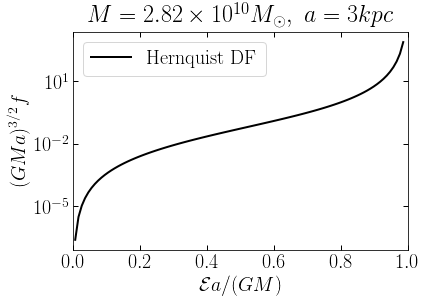

In [16]:
semilogy(eps_edges*3/(2.82E10*4.30071e-6), df_h*(2.82E10*4.30071e-6*3)**(3/2.), c='k', lw=2, label='Hernquist DF')
xlabel(r'$\mathcal{E} a / (GM)$')
ylabel(r'$(GMa)^{3/2} f$')
xlim(0, 1)
legend()
title(r'$M=2.82 \times 10^{10} M_{\odot}, \ a=3 kpc$')

## Consistent with figure 4.2 in Binney and Tramaine.
## Using the energies from the DM particle of the N-body simulation

In [17]:
def analytic_nu_derivatives(nu, Psi, a, M, G=4.30071e-6):
    """
    Computes de analytic derivatives of a Hernquist number density profile.
    Uses the equations 4.49 and 4.50 in Binney and Tremaine Ed 2.
    
    Parameters:
    nu : numpy.array
        density of the tracers
        
    Psi : numpy.array
        Relative potential of the particles.
    
    """
    Psi_tilde = Psi*a/(G*M)
    factor = 1/(2*np.pi*a**2*G*M)
    dnu_dpsi_a = factor * (Psi_tilde**3 * (4-3*Psi_tilde)) / (1-Psi_tilde)**2
    dnu2_dpsi2_a = factor/(G*M) * (2*Psi_tilde**2)*(6-8*Psi_tilde + 3*Psi_tilde**2)/(1-Psi_tilde)**3
    
    return Psi_tilde, dnu_dpsi_a, dnu2_dpsi2_a
    

In [22]:
psi_a, dnu_dpsi_a, dnu2_dpsi2_a = analytic_nu_derivatives(nu_tracer, psi_hr, a=3, M=2.82E10)

NameError: name 'nu_tracer' is not defined

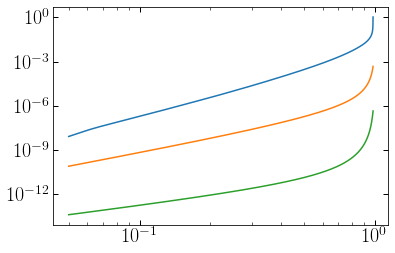

In [20]:
loglog(psi_a, nu_tracer)
loglog(psi_a, dnu_dpsi_a)
loglog(psi_a, dnu2_dpsi2_a)

In [11]:
snapshot = './halos/LMC1_97K_vir_000'


pp = readsnap(snapshot, 'pos', 'dm')
vv = readsnap(snapshot, 'vel', 'dm')
mass = readsnap(snapshot, 'mass', 'dm')
Epp = readsnap(snapshot, 'pot', 'dm')
ids = readsnap(snapshot, 'pid', 'dm')


r = np.sqrt(pp[:,0]**2+pp[:,1]**2+pp[:,2]**2)

# truncating the halo

r_cut = index = np.where(r<100)[0]

pp = pp[r_cut]
r = r[r_cut]
vv = vv[r_cut]
mass = mass[r_cut]
Epp = Epp[r_cut]
ids = ids[r_cut]

v = np.sqrt(vv[:,0]**2 + vv[:,1]**2 + vv[:,2]**2)


Returning DM    Positions
Returning DM    Velocities
Returning DM    Mass
Returning DM    Potential
Returning DM    Particle IDs


In [12]:
## Energies:

#r_interp, pot_interp, psi, Hist_E, Edges, Histo_epsilon, epsedges

In [23]:
rbins, pot, psi, E, Histo_E, Edges, Histo_epsilon, eps_edges = energies(r, Epp, v, 1000, 100)

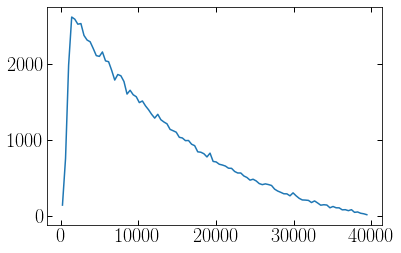

In [25]:
# Something weird here!
plot(eps_edges[:-1], Histo_epsilon) 


In [35]:
figure(figsize=(6, 10))

for i in range(10000, 12000, 500):
    r_hr,  nu_tracer, psi_hr, dnu_dpsi_smooth, dnu2_dpsi2_smooth = densities_derivatives(rbins, 
                                                                                         psi, 
                                                                                         interp_bins=i,
                                                                                         profile='Hernquist')
    subplot(4, 1, 1)
    loglog(r_hr, nu_tracer)
    ylabel(r'$\nu(r)$')
    
    subplot(4, 1, 2)
    loglog(r_hr, psi_hr)
    ylabel(r'$\Psi(r)$')

    subplot(4, 1, 3)
    loglog(r_hr, dnu_dpsi_smooth)
    ylabel(r'$\frac{d\nu}{d\Psi}$')

    subplot(4, 1, 4)
    loglog(r_hr, dnu2_dpsi2_smooth)
    ylabel(r'$\frac{d^2\nu}{d\Psi^2}$')
    xlabel(r'$r[kpc]$')
    



error: failed in converting 2nd argument `y' of dfitpack.fpcurf0 to C/Fortran array

Text(0,0.5,'$\\nu, d\\nu d\\Psi, d\\nu^2 d \\Psi^2$')

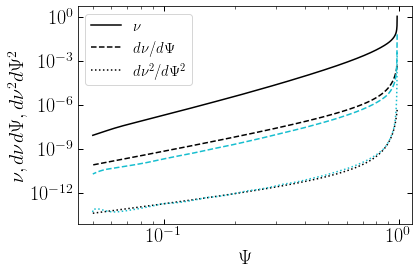

In [69]:

loglog(psi_a, nu_tracer, label=r'$\nu$', ls='-', c='k')
loglog(psi_a, dnu_dpsi_a, label=r'$d\nu/d\Psi$', ls='--', c='k')
loglog(psi_a, dnu2_dpsi2_a, label=r'$d\nu^2/d\Psi^2$', ls=':', c='k')

loglog(psi_a, dnu_dpsi_smooth, c='C9', ls='--')
loglog(psi_a, dnu2_dpsi2_smooth, c='C9', ls=':')

legend(fontsize=15)
xlabel(r'$\Psi$')
ylabel(r'$\nu, d\nu d\Psi, d\nu^2 d \Psi^2$')
#savefig('derivatives_dnu_dpsi.pdf', bbox_inches='tight')



In [70]:
df = distribution_function(psi_hr, dnu2_dpsi2_smooth, eps_edges)

0
0
0
0
0
1311
3310
4513
5373
6055
6624
7101
7495
7827
8114
8366
8590
8787
8963
9119
9260
9388
9505
9614
9714
9807
9892
9970
10043
10111
10174
10233
10289
10342
10392
10439
10484
10525
10565
10602
10638
10671
10703
10734
10763
10791
10818
10844
10869
10892
10915
10936
10957
10977
10997
11015
11033
11051
11067
11084
11099
11114
11129
11143
11157
11170
11183
11196
11208
11220
11232
11243
11254
11264
11275
11285
11295
11304
11314
11323
11331
11340
11349
11357
11365
11373
11381
11388
11396
11403
11410
11417
11424
11431
11439
11446
11454
11462
11471
11482
11500


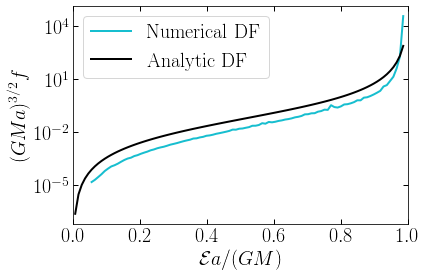

In [23]:
plt.semilogy(eps_edges*3/(2.82E10*4.30071e-6), (df*(2.82E10*4.30071e-6*3)**(3/2.)), c='C9', lw=2, label='Numerical DF')
semilogy(eps_edges*3/(2.82E10*4.30071e-6), df_h*(2.82E10*4.30071e-6*3)**(3/2.), c='k', lw=2, label='Analytic DF')

xlabel(r'$\mathcal{E} a / (GM)$')
ylabel(r'$(GMa)^{3/2} f$')
xlim(0, 1)
legend()

savefig('DF_Hernquist.pdf', bbox_inches='tight')

## Density of states:

\begin{equation}
g(E) = (4\pi)^2 \int_0^{r_E} r^2 \sqrt{2(E-\Phi(r))} dr
\end{equation}

In [24]:
def density_of_states(rbins, E, pot):
    """
    Compute the density of states.
    
    g(E) = (4\pi)^2 \int_0^{r_E} r^2 \sqrt{2(E-\Phi(r))} dr
    
    Parameters:
    -----------
    rbins : numpy.array
        Array with
    E : numpy.array
        Total Energy.
    pot: numpy.array
        Potential Energy.
    
    Returns:
    --------
    
    g_E : numpy.array
        Density of states.
    
    """
    
    factor = (4*np.pi)**2
    g_E = np.zeros(len(E))
    
    dr = np.zeros(len(rbins))
    for i in range(1,len(dr)):
        dr[i] = rbins[i]-rbins[i-1]
        
    
    for i in range(len(E)):
        index = np.where(pot<=E[i])[0]
        if len(index)==0:
            g_E[i] = 0
            print('here')
        else:
            r = rbins[index]
            g_E[i] = factor*np.sum(r**2 * np.sqrt(2*dr[index]*(E[i]-pot[index])))
    
    return g_E

In [25]:
g_E = density_of_states(rbins, Edges, pot)

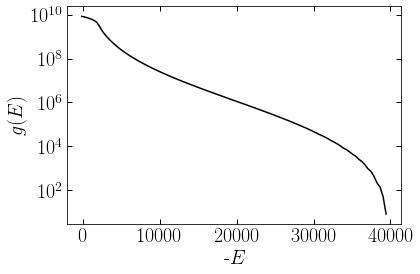

In [26]:
semilogy(-Edges, g_E, c='k')
xlabel('-$E$')
ylabel('$g(E)$')
plt.savefig('gE.pdf', bbox_inches='tight')

In [55]:
def differential_energy_distribution(hist_E, E_bins, m_part):
    """
    Differential Energy distribution.
    
    N(E) = n / dE
    
    n : number of particles with energy [E, E+dE].
    dE : Energy interval.
    
    Parameters:
    -----------
    hist_E : 
    
    """
    N_E = np.zeros(len(hist_E))
    for i in range(len(hist_E)):
        dE = np.abs(E_bins[i+1]-E_bins[i])
        N_E[i] = hist_E[i]*m_part / dE
    
    return N_E, savitzky_golay(N_E, 13, 3) # smoothing the curve

In [56]:
Histo_E, smooth_Histo_E = differential_energy_distribution(Histo_E, Edges, mass[0]*1E10)

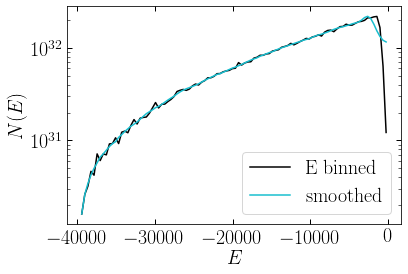

In [57]:
semilogy(Edges[:-1], Histo_E, c='k', label='E binned')
semilogy(Edges[:-1], smooth_Histo_E, c='C9', label='smoothed')
xlabel('$E$')
ylabel('$N(E)$')
legend()
plt.savefig('N_E.pdf', bbox_inches='tight')



In [61]:
print(len(smooth_Histo_E), len(g_E))

100 101


In [105]:
def cast_weights(w, E_part, E_bins):
    """
    Assigns weights to each DM particle.
    For each energy bin it finds all the particles that
    have that energy and give the weight corresponding to that
    energy bin.
    
       
    """
    part_weights = np.zeros(len(E_part))
    for i in range(1,len(E_bins)):
        index_part_E = np.where((E_part<E_bins[i]) & (E_part>=E_bins[i-1]))
        part_weights[index_part_E] = w[i]
        
    return part_weights

In [112]:
def weights(r, Epp, v, mp):
    """
    Computes weights
    
    
    """
    
    print('Number of particles : ', len(r))
    # Computes energies!
    rbins, pot, psi, E, Histo_E, Edges, Histo_epsilon, eps_edges = energies(r, Epp, v, 1000, 100)
    
    # Computes N_E
    Histo_E, N_E = differential_energy_distribution(Histo_E, Edges, mp)
    
    
    # Density of states. size = len(Edges)
    g_E = density_of_states(rbins, Edges, pot)
    
    #  Tracers densities derivatives.
    r_hr,  nu_tracer, psi_hr, dnu_dpsi_smooth, dnu2_dpsi2_smooth = densities_derivatives(rbins, 
                                                                                         psi, 
                                                                                         interp_bins=10000,
                                                                                         profile='Hernquist')
    
    # Distribution function (f size = interp_bins)
    
    f = distribution_function(psi_hr, dnu2_dpsi2_smooth, eps_edges)
    
    # Interpolating g(E) and N(E)
    n_interp = 10000
    E_edges_inter = np.linspace(min(Edges), max(Edges[:-1]), n_interp)
    
    g_E_interp = interp1d(Edges, g_E)
    g_E_I = g_E_interp(E_edges_inter)
    
    N_E_interp = interp1d(Edges[:-1], N_E)
    N_E_I = N_E_interp(E_edges_inter)
    
    f_E_interp = interp1d(-Edges, f)
    f_E_I = f_E_interp(-E_edges_inter)
    
    #print(len(g_E_I), len(N_E_I), len(f_E_I))
    
    
    # Weights
    w = f_E_I[::-1] * g_E_I / N_E_I
    
    #w_p = cast_weights(w, E, E_edges)
    #print(sum(w_p))
    return w
    

In [113]:
ww = weights(r, Epp, v, mass[0]*1E10)

Number of particles :  91508


error: failed in converting 2nd argument `y' of dfitpack.fpcurf0 to C/Fortran array

(array([  448.,  3284.,  5405.,   610.,   159.,     6.,    12.,    15.,
           18.,    43.]),
 array([  0.00000000e+00,   6.21106576e-11,   1.24221315e-10,
          1.86331973e-10,   2.48442630e-10,   3.10553288e-10,
          3.72663945e-10,   4.34774603e-10,   4.96885261e-10,
          5.58995918e-10,   6.21106576e-10]),
 <a list of 10 Patch objects>)

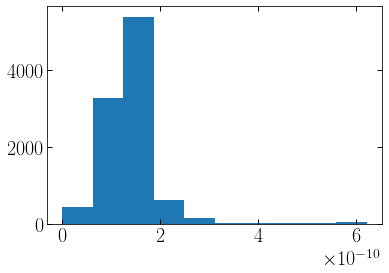

In [93]:
hist(ww)

In [36]:
len(ww)

NameError: name 'ww' is not defined